In [54]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [55]:
def getDataFrameFromZip(filename, folder=""):
    with zipfile.ZipFile(f"{folder}{'/' if folder != '' else ''}{filename}.zip", "r") as zipfolder:
        with zipfolder.open(f"{filename}.jsonl", "r") as jsonlfile:
            return pd.read_json(jsonlfile, lines=True)

In [56]:
df = getDataFrameFromZip("scored_paragraphs_english_maincategories_1k7")

In [57]:
def duplicateIfSeveralCategoriesHelper(row, dict):
    keys = ["responsedatetime", "source", "url", "title", "author", "category", "datetime", "text", "textenglish", "lemmas", "negpos"]

    for key in keys:
        if key not in dict.keys():
            dict[key] = []
    
    for category in row["categories"]:
        if pd.notna(row["negpos"]):
            for key in keys:
                if key == "category":
                    dict["category"].append(category)
                elif key == "negpos":
                    dict["negpos"].append(row["negpos"][category])
                else:
                    dict[key].append(row[key])

def duplicateIfSeveralCategories(df):
    dictionary = {}

    df.apply(lambda x: duplicateIfSeveralCategoriesHelper(x, dictionary), axis=1)

    return pd.DataFrame.from_dict(dictionary)

In [58]:
duplicateddf = duplicateIfSeveralCategories(df)

In [59]:
duplicateddf.head()

,responsedatetime,source,url,title,author,category,datetime,text,textenglish,lemmas,negpos
0,2024-04-30 10:57:37,El Confidencial,https://www.elconfidencial.com/espana/2017-05-...,Pedro Sánchez gana con rotundidad las primaria...,None,PSOE,2017-05-22 12:27:06,"Al 99,2% escrutado, los resultados de la web d...","At 99.2%, the results of the PSOE website indi...","{'escrutado': [9], 'resultado': [24, 3242, 379...",0.787579
1,2024-05-02 21:01:33,El Confidencial,https://www.elconfidencial.com/alma-corazon-vi...,'Chemsex': el fenómeno de drogas y sexo grupal...,None,DROGAS,2017-06-05 12:18:00,"Consumo de todo tipo de estupefacientes, sexo ...","Consumption of all kinds of narcotics, non-sto...","{'Consumo': [0], 'tipo': [16, 664], 'estupefac...",-0.006755
2,2024-04-30 10:46:01,El Confidencial,https://www.elconfidencial.com/medioambiente/c...,"""Estamos en la era de la ebullición"": la adver...",Jorge García González,CAMBIO CLIMÁTICO,2023-07-28 10:04:00,El mes de julio de 2023 está camino de convert...,The month of July 2023 is on the way to becomi...,"{'mes': [3, 798, 2173], 'julio': [10, 1750, 19...",0.100402
3,2024-05-02 21:02:49,El Confidencial,https://www.elconfidencial.com/espana/2023-11-...,La Policía baraja como hipótesis la autoría ir...,Alejandro Requeijo,PP,2023-11-09 19:58:00,El exlíder del PP en Cataluña Alejo Vidal-Quad...,The PP ex-leader in Catalonia Alejo Vidal-Quad...,"{'exlíder': [3], 'PP': [15, 3341], 'Cataluña':...",0.219458
4,2024-05-02 21:12:59,El Confidencial,https://www.elconfidencial.com/espana/madrid/2...,Ayuso anuncia una nueva estación de la Línea 9...,I. S. Calleja,PP,2022-10-04 10:28:00,La Comunidad de Madrid proyecta ya una nueva e...,The Community of Madrid already projects a new...,"{'Comunidad': [3, 1650], 'Madrid': [16, 671, 8...",0.599853


In [60]:
groupedbynone = duplicateddf[["source", "category", "negpos"]].groupby([ "category", "source"]).aggregate("mean")
groupedbysource = duplicateddf[["source", "negpos"]].groupby(["source"]).aggregate("mean")
groupedbycategory = duplicateddf[["category", "negpos"]].groupby(["category"]).aggregate("mean")

In [61]:
groupedbynone["negpos"].index.get_level_values(0).unique()

Index(['ABORTO', 'CAMBIO CLIMÁTICO', 'CASA REAL', 'CIUDADANOS', 'COVID-19',
       'CRISTIANISMO', 'DROGAS', 'EH BILDU', 'ERC', 'FRANQUISMO',
       'GUERRA EN UCRANIA', 'IMPUESTOS', 'INDEPENDENTISMO', 'INMIGRACIÓN',
       'IU', 'JUNTS', 'PNV', 'PODEMOS', 'PP', 'PSOE', 'SINDICATOS',
       'TERRORISMO', 'TOROS', 'VOX', 'YIHADISMO'],
      dtype='object', name='category')

In [62]:
X = np.zeros([len(groupedbynone), 2])
y = np.zeros(len(groupedbynone))

i=0

for index, row in groupedbynone.iterrows():
    category, source = index

    X[i, 0] = groupedbysource["negpos"][source]
    X[i, 1] = groupedbycategory["negpos"][category]
    y[i] = groupedbynone["negpos"][category, source]

    i += 1

    

In [63]:
regression = LinearRegression(fit_intercept=False)

In [64]:
regression.fit(X, y)

LinearRegression(fit_intercept=False)

In [65]:
bias = y-regression.predict(X)

In [66]:
bias

array([ 0.39732562, -0.0172985 ,  0.37771349, -0.04043844, -0.02471494,
        0.20496737, -0.03019225, -0.12525173, -0.1630226 ,  0.08584451,
       -0.14473276,  0.15453995,  0.07731983, -0.01711592, -0.14974916,
        0.02606082,  0.00415098,  0.18916389, -0.04061254, -0.09966642,
       -0.04612205,  0.04831805,  0.1020829 ,  0.06309309, -0.02653724,
        0.01613096, -0.00614219,  0.02693798, -0.05633414, -0.04510209,
        0.06374428, -0.04144904,  0.08486633,  0.07630592,  0.00064533,
       -0.03000644,  0.00054098,  0.01974173, -0.2266755 ,  0.05590814,
        0.04659375, -0.02082672, -0.03782222,  0.04433398,  0.00863959,
        0.027066  , -0.0654606 , -0.03713849, -0.04536105,  0.10031162,
       -0.11029492, -0.0319651 ,  0.00959123,  0.06610139,  0.1736501 ,
       -0.07009284,  0.08896541, -0.00303156, -0.02848204, -0.0488996 ,
       -0.1835745 ,  0.10902262,  0.04868526,  0.09848334, -0.10011341,
       -0.28984466,  0.02167788, -0.07833241, -0.05759248,  0.07

In [67]:
biasdf = groupedbynone.copy()

In [68]:
biasdf["bias"] = bias

In [69]:
biasdf

negpos      bias
category  source                                
ABORTO    El Confidencial     0.683637  0.397326
          El Diario           0.268052 -0.017298
          El Español          0.663222  0.377713
          El Mundo            0.245682 -0.040438
          El País             0.262799 -0.024715
...                                ...       ...
YIHADISMO La Nueva España    -0.086095 -0.115890
          La Razón           -0.014524 -0.045867
          La Vanguardia       0.112150  0.082525
          La Voz de Asturias -0.031523 -0.062598
          Público             0.102455  0.071238

[234 rows x 2 columns]

<Axes: xlabel='source', ylabel='category'>

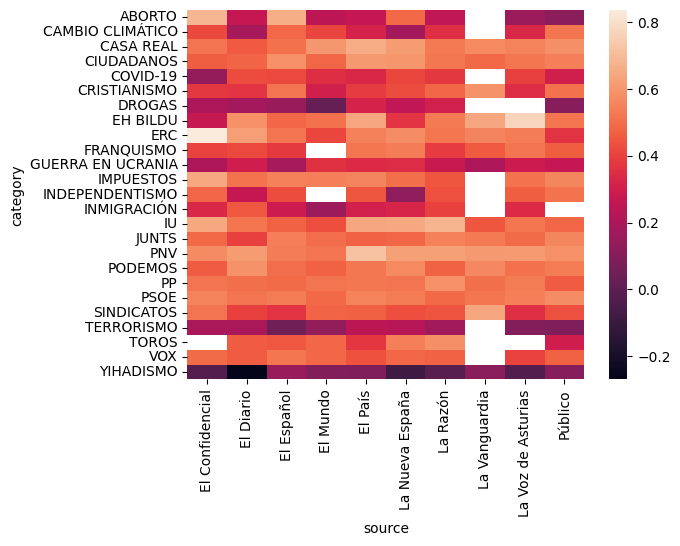

In [70]:
sns.heatmap(biasdf["negpos"].unstack())